In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

tSI_data = genfromtxt('tSI_data.csv', delimiter=',') #in the form of [t, S, I]
tao_data = genfromtxt('tao_data.csv', delimiter=',') #in the form of [t, tao_star, T_star, us]

torch.manual_seed(1234)

, grad_fn=<DivBackward0>)
epoch:  267400
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  267500
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  267600
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  267700
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  267800
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  267900
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  268000
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  268100
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  268200
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  268300
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  268400
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  268500
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  268600
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  268700
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  268800
loss:  tensor(0.0049, grad_fn=<DivBackward0>)
epoch:  268900
loss:  tensor(0.0049, grad_fn=<DivBackward0>

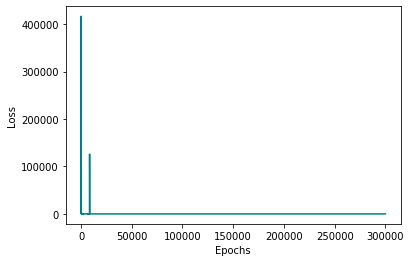

In [2]:
%%time

class DINN:
    def __init__(self, t, S_data, I_data, tao_data, T_star_data, u_data): #t, S_data, I_data, tao_data, T_star_data, u
        self.t = torch.tensor(t).float()
        self.S = torch.tensor(S_data)
        self.I = torch.tensor(I_data)
        self.taos = torch.tensor(tao_data)
        self.T_stars = torch.tensor(T_star_data)
        self.u = torch.tensor(u_data).float()

        #learnable parameters
        self.alpha1=torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.alpha2=torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.mu=torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.beta=torch.nn.Parameter(torch.rand(1, requires_grad=True))

        #NN
        self.net_si = self.net_si()
        self.net_taot = self.net_taot()

        self.params = list(self.net_si.parameters()) + list(self.net_taot.parameters())
        self.params.extend(list([self.alpha1, self.alpha2, self.mu, self.beta]))

    #nets
    class net_si(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.net_si, self).__init__()
            self.fc1=nn.Linear(1, 32) #takes t
            self.fc2=nn.Linear(32, 64)
            self.fc3=nn.Linear(64, 128)
            self.fc4=nn.Linear(128, 128)
            self.fc5=nn.Linear(128, 64)
            self.fc6=nn.Linear(64, 64)
            self.fc7=nn.Linear(64, 32)
            self.fc8=nn.Linear(32, 32)
            self.out=nn.Linear(32, 2) #outputs S, I

        def forward(self, t):
            si=F.relu(self.fc1(t))
            si=F.relu(self.fc2(si))
            si=F.relu(self.fc3(si))
            si=F.relu(self.fc4(si))
            si=F.relu(self.fc5(si))
            si=F.relu(self.fc6(si))
            si=F.relu(self.fc7(si))
            si=F.relu(self.fc8(si))
            si=self.out(si)
            return si    
    
    class net_taot(nn.Module): # input = [u]
        def __init__(self):
            super(DINN.net_taot, self).__init__()
            self.fc11=nn.Linear(1, 32) #takes u
            self.fc22=nn.Linear(32, 64)
            self.fc33=nn.Linear(64, 128)
            self.fc44=nn.Linear(128, 128)
            self.fc55=nn.Linear(128, 64)
            self.fc66=nn.Linear(64, 64)
            self.fc77=nn.Linear(64, 32)
            self.fc88=nn.Linear(32, 32)
            self.outout=nn.Linear(32, 2) #outputs tao, T*

        def forward(self, u):
            taot=F.relu(self.fc11(u))
            taot=F.relu(self.fc22(taot))
            taot=F.relu(self.fc33(taot))
            taot=F.relu(self.fc44(taot))
            taot=F.relu(self.fc55(taot))
            taot=F.relu(self.fc66(taot))
            taot=F.relu(self.fc77(taot))
            taot=F.relu(self.fc88(taot))
            taot=self.outout(taot)
            return taot    


    def net_f(self, t, u):
        si = self.net_si(t) 
        taot = self.net_taot(u) 

        S, I = si[:,0], si[:,1]
        tao, T_star = taot[:,0], taot[:,1]
        #normalizing (S max value is 2000, I max value is 600.9260)
        S_hat = S/2000 #=> S=2000*S_hat. Take this S and put it in the gradient
        I_hat = I/600.9260 #=> I=600.9260*I_hat. Take this I and put it in the gradient

        S_hat_t = grad(S_hat, t, retain_graph=True)[0][0] #derivative of S_pred wrt t              
        I_hat_t = grad(I_hat, t, retain_graph=True)[0][0] #derivative of I_pred wrt t
        
        #modified normalized equations
        f1 = (S_hat_t * 2000 + self.beta * S_hat * 2000 * I_hat * 600.9260 + u * (t > tao) * self.alpha1 * ( -S_hat * 2000)) / 2000
        f2 = (I_hat_t * 600.9260 - self.beta * S_hat * 2000 * I_hat * 600.9260 + self.mu * I_hat * 600.9260 + u * (t > tao) * self.alpha2) / 600.9260
        return f1, f2, S, I, tao, T_star
        
    
    def train(self, n_epochs):
        
        learning_rate = 0.001
        optimizer = optim.Adam(self.params, lr = learning_rate)
        #lambda1 = lambda epoch: 0.999 ** epoch
        #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1) 
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-6, max_lr=0.02, step_size_up=10000, mode="triangular2", cycle_momentum=False)
   

        # Load checkpoint
        try:
            PATH = "model.pt"
            checkpoint = torch.load(PATH)        
            self.net_si.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch = checkpoint['epoch']
            loss = checkpoint['loss']
        except RuntimeError :
            print('changed the architecture, ignore')
            pass
        except FileNotFoundError:
            pass

        #train
        print('\nstarting training...\n')
        losses = []
        
        frozen = False #a parameter to know if a part of the model is frozen

        for epoch in range(n_epochs):
            #lists to hold the output (maintain only the final epoch)
            S_pred_list= []
            I_pred_list= []
            tao_pred_list= []
            T_star_pred_list = []

            optimizer.zero_grad()
            for time_step in range(len(self.t)):

                t_value, u_value = self.t[time_step], self.u[time_step]
                t_value = torch.tensor(t_value, requires_grad=True).unsqueeze(0).unsqueeze(1)
                u_value = torch.tensor(u_value, requires_grad=True).unsqueeze(0).unsqueeze(1)
                
                f1, f2, S_pred, I_pred, tao_pred, T_star_pred = self.net_f(t_value, u_value)
                S_pred_list.append(S_pred)
                I_pred_list.append(I_pred)
                tao_pred_list.append(tao_pred)
                T_star_pred_list.append(T_star_pred)
                
                if frozen == False: #if the network wasn't frozen already, use the loss without f1,f2
                    loss = (torch.mean(torch.square(self.S[time_step]-S_pred))+torch.mean(torch.square(self.I[time_step]-I_pred)))

                else: #use the entire loss 
                    loss = (torch.mean(torch.square(self.S[time_step]-S_pred))+torch.mean(torch.square(self.I[time_step]-I_pred)) \
                    +torch.mean(torch.square(f1)) + torch.mean(torch.square(f2)) \
                    +torch.mean(torch.square(self.taos[time_step]-tao_pred)) + torch.mean(torch.square(self.T_stars[time_step]-T_star_pred)))/100

                #freeze network
                if loss < 1 and frozen == False and epoch > 30000: #if the loss is low and the network wasn't frozen already, and epoch > value (until its stabilized)
                    for param in self.net_si.parameters(): #freeze network
                        param.requires_grad = False
                    frozen = True
                    print('\nfreezing network net_si\n')

                loss.backward()
                #torch.nn.utils.clip_grad_norm_(self.net_si.parameters(), 100) #gradient clipping
            optimizer.step()
            scheduler.step() #scheduler

            losses.append(loss)
            if epoch % 100 == 0:
                print('epoch: ', epoch)
                print('loss: ' ,loss)

        #checkpoint save
        PATH = "model.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.net_si.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)

        #plot
        plt.plot(losses, color = 'teal')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        return S_pred_list, I_pred_list, tao_pred_list, T_star_pred_list

dinn = DINN(tSI_data[0], tSI_data[1], tSI_data[2], tao_data[1], tao_data[2], tao_data[3]) #t, S_data, I_data, tao_data, T_star_data, u
S_pred_list, I_pred_list, tao_pred_list, T_star_pred_list = dinn.train(300000) #train

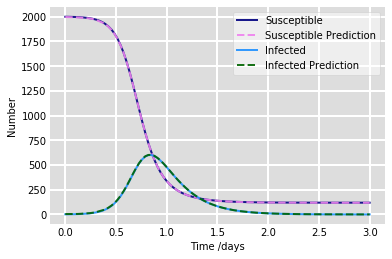

In [3]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tSI_data[0], tSI_data[1], 'navy', alpha=0.9, lw=2, label='Susceptible')
ax.plot(tSI_data[0], S_pred_list, 'violet', alpha=0.9, lw=2, label='Susceptible Prediction', linestyle='dashed')
ax.plot(tSI_data[0], tSI_data[2], 'dodgerblue', alpha=0.9, lw=2, label='Infected')
ax.plot(tSI_data[0], I_pred_list, 'darkgreen', alpha=0.9, lw=2, label='Infected Prediction', linestyle='dashed')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

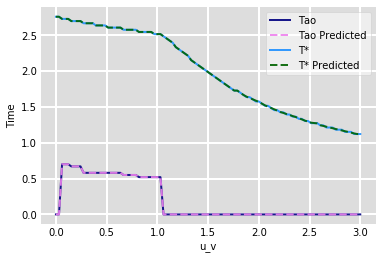

In [4]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tao_data[3], tao_data[1], 'navy', alpha=0.9, lw=2, label='Tao')
ax.plot(tao_data[3], tao_pred_list,'violet', alpha=0.9, lw=2, label='Tao Predicted', linestyle='dashed')
ax.plot(tao_data[3], tao_data[2], 'dodgerblue', alpha=0.9, lw=2, label='T*')
ax.plot(tao_data[3], T_star_pred_list, 'darkgreen', alpha=0.9, lw=2, label='T* Predicted', linestyle='dashed')
ax.set_xlabel('u_v')
ax.set_ylabel('Time')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [5]:
print('alpha1: (goal 1)', dinn.alpha1)
print('\nalpha2: (goal 0)', dinn.alpha2)
print('\nbeta: (goal 0.0075): ', dinn.beta)
print('\nmu (goal 5): ', dinn.mu)


alpha1: (goal 1) Parameter containing:
tensor([0.0154], requires_grad=True)

alpha2: (goal 0) Parameter containing:
tensor([-0.5030], requires_grad=True)

beta: (goal 0.0075):  Parameter containing:
tensor([0.0071], requires_grad=True)

mu (goal 5):  Parameter containing:
tensor([4.9090], requires_grad=True)


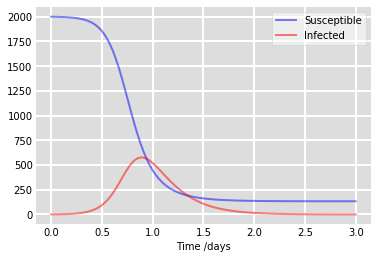

In [6]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
#N = 2000
# Initial number of infected individuals, I0
I0 = 1
# Everyone else, S0, is susceptible to infection initially.
S0 = 2000
# Contact rate, beta, and mean recovery rate, mu.
beta, mu = dinn.beta, dinn.mu
#beta, mu = 0.0075, 5
# A grid of time points (in days)
t = np.linspace(0, 3, 100) 

# The SIR model differential equations.
def deriv(y, t, beta, mu):
    S, I = y
    dSdt = -beta * S * I 
    dIdt = beta * S * I - mu * I
    return dSdt, dIdt

# Initial conditions vector
y0 = S0, I0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(beta, mu))
S, I = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='Infected')
ax.set_xlabel('Time /days')
#ax.set_ylabel('Number (1000s)')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

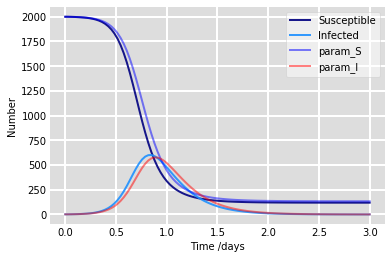

In [7]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tSI_data[0], tSI_data[1], 'navy', alpha=0.9, lw=2, label='Susceptible')
ax.plot(tSI_data[0], tSI_data[2], 'dodgerblue', alpha=0.9, lw=2, label='Infected')
ax.plot(t, S, 'b', alpha=0.5, lw=2, label='param_S')
ax.plot(t, I, 'r', alpha=0.5, lw=2, label='param_I')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()